In [160]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import *
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.utils.data as Data

In [161]:
parser = argparse.ArgumentParser()

parser.add_argument('--path', type = str, default = 'stock_data')
parser.add_argument('--label', type = str, default = 'Price')

parser.add_argument('--test_size', type = float, default = 0.1)
parser.add_argument('--seq_size', type = float, default = 20)

parser.add_argument('--epochs', type = int, default = 5)
parser.add_argument("--lr", type=float, default = 0.001)

parser.add_argument('--batch_size', type = int, default = 256)

parser.add_argument('--layer_size', type = int, default = 2)
parser.add_argument('--input_size', type = int, default = 8)
parser.add_argument('--hidden_size', type = int, default = 64)
parser.add_argument('--output_size', type = int, default = 1)

args = parser.parse_args(args=[])

In [162]:
df_list = [pd.read_csv(os.path.join(args.path, i)) for i in os.listdir(args.path)]

In [163]:
scaler = MinMaxScaler(feature_range=(-1, 1))
for i in range(len(df_list)):
    for col in df_list[i].columns:
        df_list[i][col] = scaler.fit_transform(df_list[i][col].values.reshape(-1,1))

In [164]:
test_set_size = int(args.test_size * sum([len(df) for df in df_list]))

# feat, target = create_seq_data(df_list, args)
# np.save(f'input\data_X_Regression_size_{args.input_size}.npy', feat)
# np.save(f'input\data_y_Regression_size_{args.input_size}.npy', target)

feat = np.load(f'input\data_X_Regression_size_{args.input_size}.npy')
target = np.load(f'input\data_y_Regression_size_{args.input_size}.npy')
trainX, trainY, testX, testY = train_test(feat, target, test_set_size, args.seq_size, args.input_size)

In [165]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset = PriceDataSet(trainX, trainY)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=0
)

test_dataset = PriceDataSet(testX, testY)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=0
)

model = resLSTM(args.input_size, args.hidden_size, args.layer_size, args.output_size).to(device)

criterion = torch.nn.MSELoss(size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

model

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


resLSTM(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 0/5


  0%|          | 0/391 [00:00<?, ?it/s]D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 96%|█████████▌| 376/391 [00:02<00:00, 182.31it/s]D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([42, 1])) that is different to the input size (torch.Size([42, 42])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 391/391 [00:02<00:00, 173.41it/s]
D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([56, 1])) that is different to the 

0 Train Loss: 8.0513
0 Test Loss: 331.9084
Epoch 1/5


100%|██████████| 391/391 [00:02<00:00, 185.63it/s]


1 Train Loss: 5.6096
1 Test Loss: 315.9703
Epoch 2/5


100%|██████████| 391/391 [00:02<00:00, 177.67it/s]


2 Train Loss: 7.5915
2 Test Loss: 313.7672
Epoch 3/5


100%|██████████| 391/391 [00:02<00:00, 186.07it/s]


3 Train Loss: 6.3368
3 Test Loss: 310.5566
Epoch 4/5


100%|██████████| 391/391 [00:02<00:00, 184.84it/s]


4 Train Loss: 7.4824
4 Test Loss: 312.7246


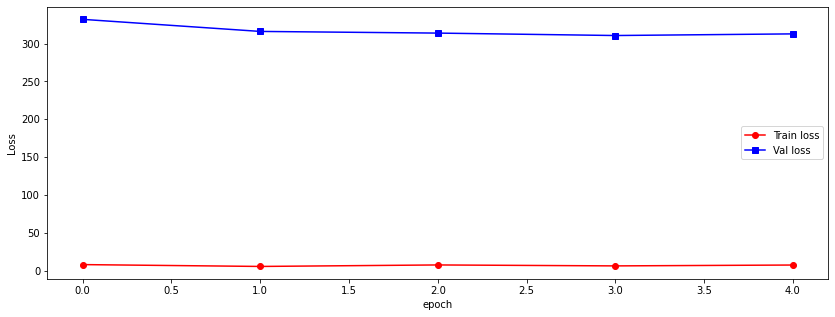

done


In [166]:
train_loss_all = []
train_acc_all = []
test_loss_all = []
test_acc_all = []

for epoch in range(args.epochs):
    print('Epoch {}/{}'.format(epoch, args.epochs))

    model.train()
    train_num = 0
    for (b_x, b_y) in tqdm(train_loader):
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        output = model(b_x)

        loss = criterion(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss += 100000 * loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(float(loss) / train_num)
    print('{} Train Loss: {:.4f}'.format(epoch, train_loss_all[-1]))


    model.eval()
    test_num = 0
    for (b_x, b_y) in test_loader:
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        output = model(b_x)

        loss = criterion(output, b_y)
        loss += 100000 * loss.item() * b_x.size(0)
        test_num += b_x.size(0)
    test_loss_all.append(float(loss) / test_num)
    print('{} Test Loss: {:.4f}'.format(epoch, test_loss_all[-1]))

plt.figure(figsize=(14, 5))
plt.plot(train_loss_all, 'ro-', label = 'Train loss')
plt.plot(test_loss_all, 'bs-', label = 'Val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
print('done')

In [167]:
# torch.save(model, 'models/LSTM.pkl')
torch.save(model, 'models/res_LSTM.pkl')